Start with something simple, 2D, and only slightly nongaussian. The first will be a parabola-shaped gaussian-based pdf.

In [6]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

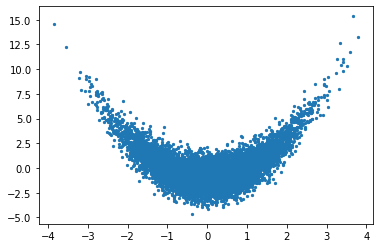

In [8]:
# Sample from the initial distribution
nsamples=10000
X_para = np.random.normal(0, 1, nsamples) 
Y_para = np.random.normal(X_para**2-1,1,nsamples)

plt.scatter(X_para,Y_para,s=5)

The example here is just going to be two 2d gaussians. Now to set up the MADE.


In [9]:
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation='sigmoid') # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution_para = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution_para.log_prob(x_)
model_para = tfk.Model(x_, log_prob_)

model_para.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata_para = np.stack([X_para, Y_para], axis=-1)
ydata_para = base_distribution.sample(nsamples)

batch_size = 100
model_para.fit(x=xdata_para,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=50,  # Usually `n // batch_size`.
          validation_split=0.3,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
50/50 [==============================] - 0s 3ms/step - loss: 3.4155 - val_loss: 3.3395
Epoch 2/100
50/50 [==============================] - 0s 1ms/step - loss: 3.4425 - val_loss: 3.3405
Epoch 3/100
50/50 [==============================] - 0s 1ms/step - loss: 3.3960 - val_loss: 3.3357
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 3.3876 - val_loss: 3.3330
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 3.4045 - val_loss: 3.3344
Epoch 6/100
50/50 [==============================] - 0s 1ms/step - loss: 3.3905 - val_loss: 3.3309
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 3.4002 - val_loss: 3.3276
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 3.3958 - val_loss: 3.3261
Epoch 9/100
50/50 [==============================] - 0s 1ms/step - loss: 3.3994 - val_loss: 3.3262
Epoch 10/100
50/50 [==============================] - 0s 1ms/step - loss: 3.3631 - val_loss: 3.3197
Epoch 11/

50/50 [==============================] - 0s 1ms/step - loss: 2.8747 - val_loss: 2.8527
Epoch 84/100
50/50 [==============================] - 0s 1ms/step - loss: 2.8807 - val_loss: 2.8530
Epoch 85/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8808 - val_loss: 2.8522
Epoch 86/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8686 - val_loss: 2.8514
Epoch 87/100
50/50 [==============================] - 0s 1ms/step - loss: 2.8710 - val_loss: 2.8494
Epoch 88/100
50/50 [==============================] - 0s 1ms/step - loss: 2.8743 - val_loss: 2.8548
Epoch 89/100
50/50 [==============================] - 0s 1ms/step - loss: 2.8871 - val_loss: 2.8477
Epoch 90/100
50/50 [==============================] - 0s 1ms/step - loss: 2.8544 - val_loss: 2.8500
Epoch 91/100
50/50 [==============================] - 0s 1ms/step - loss: 2.8863 - val_loss: 2.8483
Epoch 92/100
50/50 [==============================] - 0s 1ms/step - loss: 2.8659 - val_loss: 2.8456
Epoch 93/100


Looks pretty Gausian! Now lets apply a fit, determine the full gaussian map, and plot some contours.

[[[-4.   -4.  ]
  [-4.   -3.99]
  [-4.   -3.98]
  ...
  [-4.    3.97]
  [-4.    3.98]
  [-4.    3.99]]

 [[-3.99 -4.  ]
  [-3.99 -3.99]
  [-3.99 -3.98]
  ...
  [-3.99  3.97]
  [-3.99  3.98]
  [-3.99  3.99]]

 [[-3.98 -4.  ]
  [-3.98 -3.99]
  [-3.98 -3.98]
  ...
  [-3.98  3.97]
  [-3.98  3.98]
  [-3.98  3.99]]

 ...

 [[ 3.97 -4.  ]
  [ 3.97 -3.99]
  [ 3.97 -3.98]
  ...
  [ 3.97  3.97]
  [ 3.97  3.98]
  [ 3.97  3.99]]

 [[ 3.98 -4.  ]
  [ 3.98 -3.99]
  [ 3.98 -3.98]
  ...
  [ 3.98  3.97]
  [ 3.98  3.98]
  [ 3.98  3.99]]

 [[ 3.99 -4.  ]
  [ 3.99 -3.99]
  [ 3.99 -3.98]
  ...
  [ 3.99  3.97]
  [ 3.99  3.98]
  [ 3.99  3.99]]]


NameError: name 'x' is not defined

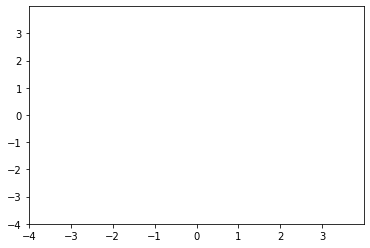

In [11]:
from scipy.stats import multivariate_normal

# This is just a fixed gaussian. I first want to see how this lines up with the samples

dist_x, dist_y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((dist_x, dist_y))

print(pos)
rv = multivariate_normal([0., 0.], [[1.0, 0.], [0., 1.0]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contour(dist_x, dist_y, rv.pdf(pos),colors='w')
ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

In [12]:
'''
Here what I am doing is finding values to perform the fit. I can start with using the previous histgram and using
a midpoint approximation.
'''

#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
results = np.stack(ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[0])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2])
binx=[]
biny=[]
edge_x = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[1]
edge_y = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[2]

for i in range(len(edge_x)-1):
    binx.append((edge_x[i+1]-edge_x[i])/2 + edge_x[i])
for i in range(len(edge_y)-1):
    biny.append((edge_y[i+1]-edge_y[i])/2 + edge_y[i])

bins=[]
z=[]
#bins.append(binx)
#bins.append(biny)
xvals = []
yvals = []

for i in range(len(binx)-1):
    for j in range(len(biny)-1):
        xvals.append(binx[i])
        yvals.append(biny[j])
        z.append(results[i][j])
        
#print(xvals)
#print(yvals)
#print(z)

NameError: name 'x' is not defined

In [13]:
# Instead of relying on a perfect gaussian, instead I will perform a fit so that We can see where the loss 
# comes from. Ideally will have mean=(0,0) and cov=diag(1,1)

# Thanks https://stackoverflow.com/questions/52148141/2d-gaussian-fit-using-lmfit 
# since it has been so long since I used lmfit

from lmfit import Parameters, minimize, report_fit

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0)

def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    sigma_y = p["sigma_y"].value
    return (z - height*gaussian2D(x,y, cen_x, cen_y, sigma_x, sigma_y))

initial = Parameters()
initial.add("height",value=1.)
initial.add("centroid_x",value=0.)
initial.add("centroid_y",value=0.)
initial.add("sigma_x",value=1.)
initial.add("sigma_y",value=1.)

fit = minimize(residuals, initial, args=(xvals,yvals, z))
print(report_fit(fit))

# need to implement a covariance term in the model

NameError: name 'xvals' is not defined

In [14]:
# Now plot the fit over the histogram
Xvals = np.linspace(-4,4,100)
Yvals = np.linspace(-4,4,100)
Xvals,Yvals = np.meshgrid(Xvals, Yvals)

xo = fit.params["centroid_x"].value
yo = fit.params["centroid_y"].value
sx = fit.params["sigma_x"].value
sy = fit.params["sigma_y"].value

Z=gaussian2D(Xvals,Yvals,xo,yo,sx,sy)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

NameError: name 'fit' is not defined

Now lets evaluate the NN fit. First I will take the sampled data and map it back to the non-gaussian parameter space. Then I will map the contours of the gaussian fit to the non-gaussian parameter space.

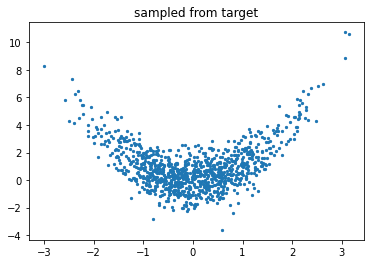

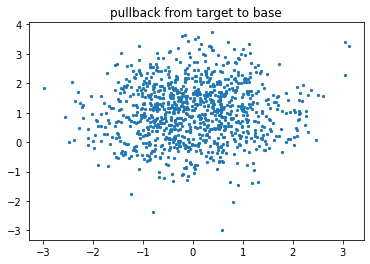

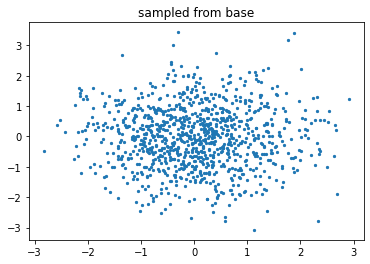

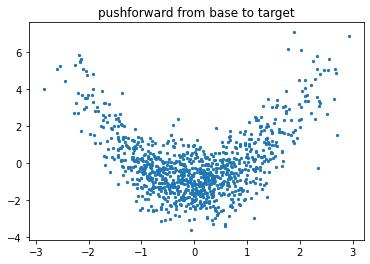

In [15]:
'''
1. Sample from original distribution
2. pull back from the original to the gaussian using the NN bijector inverse
3. sample from gaussian
4. push forward from the gaussian to the original using NN bijector
'''

# resample from target distribution
X = np.random.normal(0, 1, 1000) 
Y = np.random.normal(X**2,1,1000)

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution_para.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution_para.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

Cool!

In [16]:
# Evaluate fit on gaussian, pushforward to find contours

x_points , y_points = np.mgrid[-3:3:.05, -3:3:.05]
xy_points = np.stack((x_points, y_points),axis=-1)
print(x_points)
print(y_points)
z_vals=gaussian2D(x_points,y_points,xo,yo,sx,sy)
x_pos=[]
y_pos=[]

#for i in range(len(x_points)):
#    for j in range(len(y_points)):
#        pos=xy_points[i][j]
#        z_vals.append(gaussian2D(pos[0],pos[1],xo,yo,sx,sy))
#        append to list to use when evaluating NN model
#        x_pos.append(pos[0])
#        y_pos.append(pos[1])

# pushforward points to target distribution
contour_pushforward = target_distribution.bijector.forward(tf.cast(xy_points,tf.float32))

contour_x = contour_pushforward[...,0].numpy()
contour_y = contour_pushforward[...,1].numpy()
    
#np.stack((contour_x,contour_y),axis=-1)
#print(contour_x)
#print(contour_y)

[[-3.   -3.   -3.   ... -3.   -3.   -3.  ]
 [-2.95 -2.95 -2.95 ... -2.95 -2.95 -2.95]
 [-2.9  -2.9  -2.9  ... -2.9  -2.9  -2.9 ]
 ...
 [ 2.85  2.85  2.85 ...  2.85  2.85  2.85]
 [ 2.9   2.9   2.9  ...  2.9   2.9   2.9 ]
 [ 2.95  2.95  2.95 ...  2.95  2.95  2.95]]
[[-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 ...
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]]


NameError: name 'xo' is not defined

NameError: name 'contour_x' is not defined

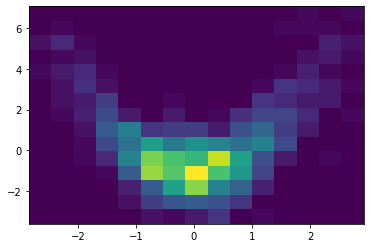

In [17]:
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')

In the plot above, what I did was take the gaussian contours and map them under the bijector from the neural net. We can see that this matches well with the initial generated distribution. Lastly, lets try to estimate the mass above 0. My strategy is as follows:

1. Using the contours found above, determine the contour that passes through the origin.
2. Sample points from the normalized space and map them to the 

NameError: name 'contour_x' is not defined

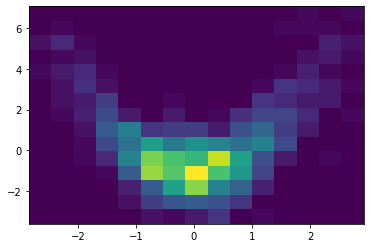

In [18]:
## Add a visualization for the origin

fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')
ax.plot([0,0],[-4,10],color='k',linestyle='dashed')
ax.plot([-5,5],[0,0],color='k',linestyle='dashed')
ax.scatter(0,0,color='k')

In [19]:
# Visualize what happens to the origin in the original parameter space under the pullback

origin_pullback = target_distribution.bijector.inverse([0.,0.])
print(origin_pullback)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot([0,0],[-4,4],color='k',linestyle='dashed')
ax3.plot([-4,4],[0,0],color='k',linestyle='dashed')
ax3.plot([-4,4],[1,1],color='k',linestyle='dashed')
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])
ox_pb = origin_pullback.numpy()[0]
oy_pb = origin_pullback.numpy()[1]
ax3.scatter(ox_pb,oy_pb,color='k')

NameError: name 'target_distribution' is not defined

In [20]:
# Compare pdf values. Use the prob from original distribution to compute MC integral

#po_pb=gaussian2D(ox_pb,oy_pb,xo,yo,sx,sy)
#print(po_pb)

prob = target_distribution_para.prob([0.,0.])
print(prob)

tf.Tensor(0.09676852, shape=(), dtype=float32)


120
120


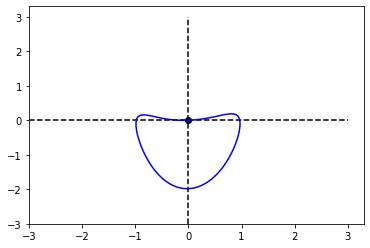

In [21]:
# Plot contour

z_vals = target_distribution_para.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-3,3],color='k',linestyle='dashed')
ax.plot([-3,3],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

To compute the integral, I can sample from the gaussian and use monte carlo integration. I can test whether a point lies in the 0-contour region of the domain. I don't know how to do error analysis for monte carlo integration, so I cannot implement anything in that regard right now.

In [22]:
# integrate

n_points = 10000
n_pass = 0

_s = target_distribution_para.sample(n_points)
_v = target_distribution_para.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print(n_pass/n_points)

0.3923


Now lets try another simple example: two 2d gaussians separated in space. This time the distribution is multimodal, so the contour passing through the origin may be more complicated. I have tried this a few times, and the main problem it has is that it just tries to shift the two gaussians, so the inverse map does nothing more than stretch along some axis. You can see the loss function is much higher at the end of the training than for the above case. Bijectors must be smooth functions, so there is a restriction about how the shift can occur.

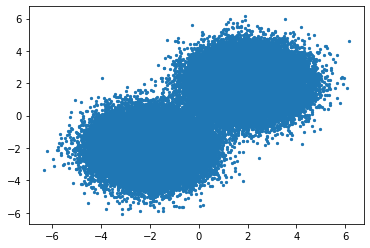

In [23]:
# Create the initial distribution
nsamples=100000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [24]:
## Create the initial distribution
nsamples=100000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

#plt.scatter(X,Y,s=5)

## NN setup
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[4,4], activation=tf.math.asinh) # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

#use multiple bijectors, should hopefully get a better result
bijectors=[]
n_bijectors = 3
for i in range(n_bijectors):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
    
target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.Chain(bijectors))#tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 1000
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=80,  # Usually `n // batch_size`.
          validation_split=0.2,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
80/80 [==============================] - 1s 5ms/step - loss: 5.1487 - val_loss: 4.5335
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 3.9424 - val_loss: 4.2260
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 3.8258 - val_loss: 4.1184
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 3.8100 - val_loss: 4.0901
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 3.7962 - val_loss: 4.0766
Epoch 6/100
80/80 [==============================] - 0s 3ms/step - loss: 3.7836 - val_loss: 4.0609
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 3.7725 - val_loss: 4.0448
Epoch 8/100
80/80 [==============================] - 0s 3ms/step - loss: 3.7629 - val_loss: 4.0433
Epoch 9/100
80/80 [==============================] - 0s 3ms/step - loss: 3.7547 - val_loss: 4.0260
Epoch 10/100
80/80 [==============================] - 0s 3ms/step - loss: 3.7477 - val_loss: 4.0298
Epoch 11/

80/80 [==============================] - 0s 3ms/step - loss: 3.6964 - val_loss: 3.9456
Epoch 84/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6941 - val_loss: 3.9482
Epoch 85/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6946 - val_loss: 3.9675
Epoch 86/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6953 - val_loss: 3.9741
Epoch 87/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6951 - val_loss: 3.9704
Epoch 88/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6958 - val_loss: 3.9818
Epoch 89/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6954 - val_loss: 3.9818
Epoch 90/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6938 - val_loss: 3.9343
Epoch 91/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6943 - val_loss: 3.9612
Epoch 92/100
80/80 [==============================] - 0s 3ms/step - loss: 3.6946 - val_loss: 3.9787
Epoch 93/100


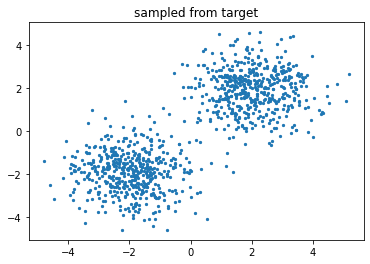

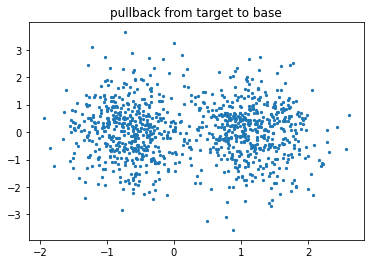

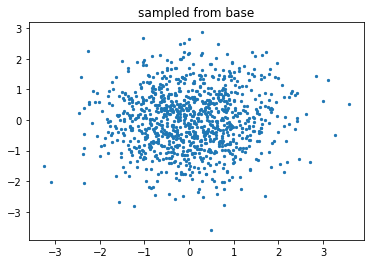

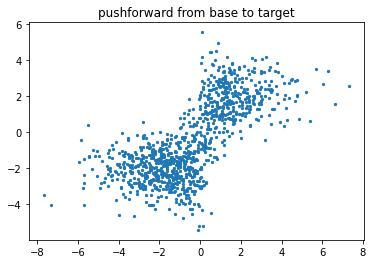

In [25]:
### Check bijector
# resample from target distribution
nsamples=1000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.033628393, shape=(), dtype=float32)
2000
2000
integral =  0.4421


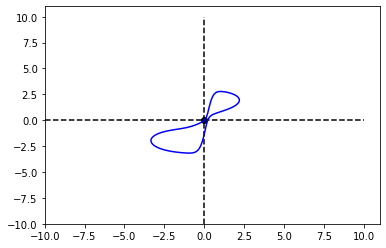

In [26]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)

One more example. Lets instead combine the two previous examples!

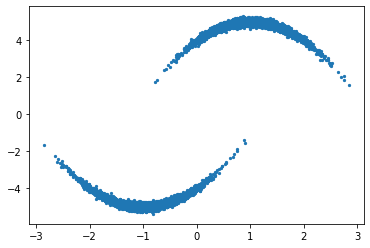

In [27]:
# Create the initial distribution

nsamples=10000
center = 1
stdevx = 0.5
stdevy = 0.1
shifty = 5

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [28]:
## NN setup

# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[8,8], activation=tf.math.asinh) # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 80
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=100,  # Usually `n // batch_size`.
          validation_split=0.2,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
100/100 [==============================] - 0s 2ms/step - loss: 10.4885 - val_loss: 8.2026
Epoch 2/100
100/100 [==============================] - 0s 1ms/step - loss: 5.5105 - val_loss: 5.1370
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 4.2717 - val_loss: 4.2376
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 3.8036 - val_loss: 3.9190
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 3.5691 - val_loss: 3.8137
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 3.4276 - val_loss: 3.8083
Epoch 7/100
100/100 [==============================] - 0s 1ms/step - loss: 3.3547 - val_loss: 3.8267
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 3.3282 - val_loss: 3.8322
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 3.3140 - val_loss: 3.8287
Epoch 10/100
100/100 [==============================] - 0s 1ms/step - loss: 3.3020 - val_l

100/100 [==============================] - 0s 2ms/step - loss: 1.7289 - val_loss: 3.9692
Epoch 82/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7213 - val_loss: 3.9298
Epoch 83/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7210 - val_loss: 4.0324
Epoch 84/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7118 - val_loss: 4.0607
Epoch 85/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7133 - val_loss: 4.1251
Epoch 86/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7134 - val_loss: 4.1598
Epoch 87/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7050 - val_loss: 4.1004
Epoch 88/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6898 - val_loss: 3.9024
Epoch 89/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6994 - val_loss: 4.0778
Epoch 90/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6859 - val_loss: 

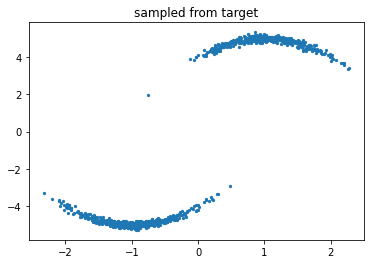

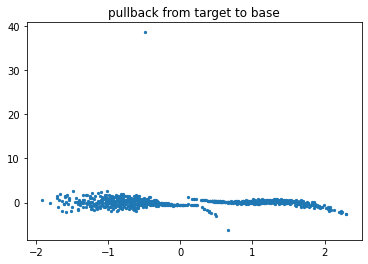

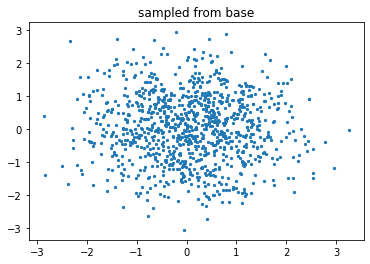

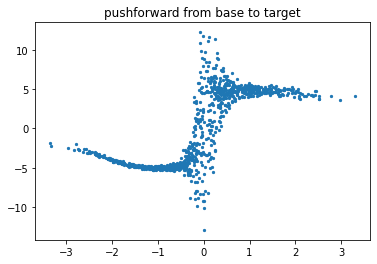

In [29]:
### Check bijector
# resample from target distribution
nsamples=1000

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))


X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.024010083, shape=(), dtype=float32)
2000
2000
integral =  0.8444


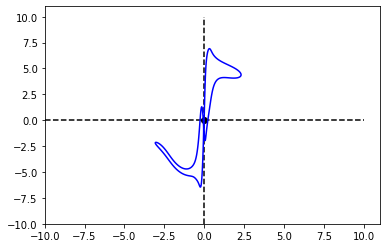

In [30]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)

I Want to explore something here. Composing bijectors successively approximating normal distriutions.

=====
run: 1
=====
Epoch 1/100
50/50 [==============================] - 0s 3ms/step - loss: 10.7065 - val_loss: 13.6054
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 8.4263 - val_loss: 10.6620
Epoch 3/100
50/50 [==============================] - 0s 1ms/step - loss: 6.7114 - val_loss: 7.9439
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 5.5306 - val_loss: 6.2807
Epoch 5/100
50/50 [==============================] - 0s 1ms/step - loss: 4.8517 - val_loss: 5.4387
Epoch 6/100
50/50 [==============================] - 0s 1ms/step - loss: 4.5035 - val_loss: 5.0363
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 4.3431 - val_loss: 4.8191
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 4.2575 - val_loss: 4.7156
Epoch 9/100
50/50 [==============================] - 0s 2ms/step - loss: 4.1930 - val_loss: 4.6575
Epoch 10/100
50/50 [==============================] - 0s 2ms/step - loss: 4.1613 - val_

Epoch 83/100
50/50 [==============================] - 0s 1ms/step - loss: 2.6567 - val_loss: 3.2664
Epoch 84/100
50/50 [==============================] - 0s 1ms/step - loss: 2.6437 - val_loss: 3.2845
Epoch 85/100
50/50 [==============================] - 0s 1ms/step - loss: 2.6607 - val_loss: 3.2615
Epoch 86/100
50/50 [==============================] - 0s 1ms/step - loss: 2.6267 - val_loss: 3.2610
Epoch 87/100
50/50 [==============================] - 0s 1ms/step - loss: 2.6275 - val_loss: 3.2321
Epoch 88/100
50/50 [==============================] - 0s 1ms/step - loss: 2.6107 - val_loss: 3.2362
Epoch 89/100
50/50 [==============================] - 0s 1ms/step - loss: 2.6186 - val_loss: 3.2427
Epoch 90/100
50/50 [==============================] - 0s 1ms/step - loss: 2.5850 - val_loss: 3.2418
Epoch 91/100
50/50 [==============================] - 0s 1ms/step - loss: 2.5993 - val_loss: 3.2044
Epoch 92/100
50/50 [==============================] - 0s 1ms/step - loss: 2.5851 - val_loss: 3.2094


Epoch 65/100
50/50 [==============================] - 0s 3ms/step - loss: 2.2053 - val_loss: 2.8035
Epoch 66/100
50/50 [==============================] - 0s 3ms/step - loss: 2.1658 - val_loss: 2.6937
Epoch 67/100
50/50 [==============================] - 0s 3ms/step - loss: 2.2074 - val_loss: 2.7660
Epoch 68/100
50/50 [==============================] - 0s 3ms/step - loss: 2.1361 - val_loss: 2.6747
Epoch 69/100
50/50 [==============================] - 0s 3ms/step - loss: 2.2156 - val_loss: 2.7142
Epoch 70/100
50/50 [==============================] - 0s 3ms/step - loss: 2.1583 - val_loss: 2.7087
Epoch 71/100
50/50 [==============================] - 0s 2ms/step - loss: 2.1311 - val_loss: 2.6579
Epoch 72/100
50/50 [==============================] - 0s 2ms/step - loss: 2.1586 - val_loss: 2.6444
Epoch 73/100
50/50 [==============================] - 0s 2ms/step - loss: 2.1582 - val_loss: 2.6443
Epoch 74/100
50/50 [==============================] - 0s 3ms/step - loss: 2.1467 - val_loss: 2.6381


Epoch 47/100
50/50 [==============================] - 0s 3ms/step - loss: 1.6663 - val_loss: 2.5914
Epoch 48/100
50/50 [==============================] - 0s 3ms/step - loss: 1.7024 - val_loss: 2.5243
Epoch 49/100
50/50 [==============================] - 0s 3ms/step - loss: 1.6493 - val_loss: 2.6846
Epoch 50/100
50/50 [==============================] - 0s 3ms/step - loss: 1.7015 - val_loss: 2.4993
Epoch 51/100
50/50 [==============================] - 0s 3ms/step - loss: 1.6490 - val_loss: 2.4847
Epoch 52/100
50/50 [==============================] - 0s 3ms/step - loss: 1.7234 - val_loss: 2.6599
Epoch 53/100
50/50 [==============================] - 0s 3ms/step - loss: 1.7169 - val_loss: 2.5914
Epoch 54/100
50/50 [==============================] - 0s 3ms/step - loss: 1.6900 - val_loss: 2.5660
Epoch 55/100
50/50 [==============================] - 0s 3ms/step - loss: 1.6294 - val_loss: 2.5846
Epoch 56/100
50/50 [==============================] - 0s 3ms/step - loss: 1.6681 - val_loss: 2.5753


Epoch 29/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6862 - val_loss: 2.6129
Epoch 30/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6269 - val_loss: 2.6065
Epoch 31/100
50/50 [==============================] - 0s 4ms/step - loss: 1.7095 - val_loss: 2.5934
Epoch 32/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6052 - val_loss: 2.5841
Epoch 33/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6194 - val_loss: 2.5931
Epoch 34/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6143 - val_loss: 2.5668
Epoch 35/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6529 - val_loss: 2.5540
Epoch 36/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6077 - val_loss: 2.5633
Epoch 37/100
50/50 [==============================] - 0s 4ms/step - loss: 1.5646 - val_loss: 2.5524
Epoch 38/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6145 - val_loss: 2.5544


Epoch 11/100
50/50 [==============================] - 0s 5ms/step - loss: 2.0203 - val_loss: 3.3592
Epoch 12/100
50/50 [==============================] - 0s 5ms/step - loss: 2.0317 - val_loss: 3.3181
Epoch 13/100
50/50 [==============================] - 0s 5ms/step - loss: 2.0107 - val_loss: 3.2557
Epoch 14/100
50/50 [==============================] - 0s 4ms/step - loss: 1.9234 - val_loss: 3.2077
Epoch 15/100
50/50 [==============================] - 0s 4ms/step - loss: 1.9306 - val_loss: 3.1595
Epoch 16/100
50/50 [==============================] - 0s 4ms/step - loss: 1.8959 - val_loss: 3.1175
Epoch 17/100
50/50 [==============================] - 0s 4ms/step - loss: 1.8958 - val_loss: 3.0780
Epoch 18/100
50/50 [==============================] - 0s 5ms/step - loss: 1.8189 - val_loss: 3.0375
Epoch 19/100
50/50 [==============================] - 0s 5ms/step - loss: 1.8589 - val_loss: 2.9971
Epoch 20/100
50/50 [==============================] - 0s 4ms/step - loss: 1.7734 - val_loss: 2.9585


Epoch 93/100
50/50 [==============================] - 0s 5ms/step - loss: 1.5201 - val_loss: 2.6901
Epoch 94/100
50/50 [==============================] - 0s 5ms/step - loss: 1.6037 - val_loss: 2.6833
Epoch 95/100
50/50 [==============================] - 0s 4ms/step - loss: 1.4351 - val_loss: 2.6923
Epoch 96/100
50/50 [==============================] - 0s 5ms/step - loss: 1.5768 - val_loss: 2.6700
Epoch 97/100
50/50 [==============================] - 0s 4ms/step - loss: 1.4890 - val_loss: 2.7186
Epoch 98/100
50/50 [==============================] - 0s 4ms/step - loss: 1.6113 - val_loss: 2.6934
Epoch 99/100
50/50 [==============================] - 0s 4ms/step - loss: 1.5053 - val_loss: 2.6771
Epoch 100/100
50/50 [==============================] - 0s 4ms/step - loss: 1.5273 - val_loss: 2.6188


"\n#print(bijectors)\nprint(dists)\ndata = bijectors[1].forward(dists[1])\nx = data[...,0]\ny = data[...,1]\nplot(x,y,'final')\n"

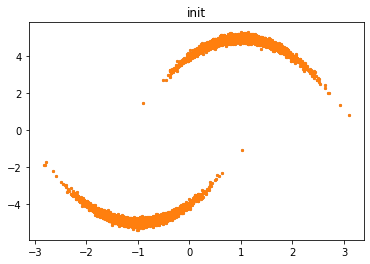

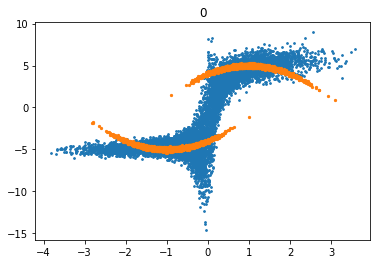

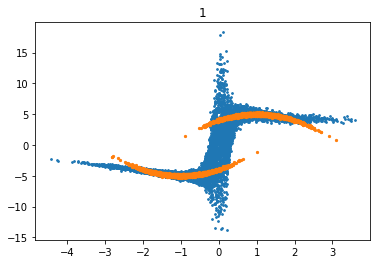

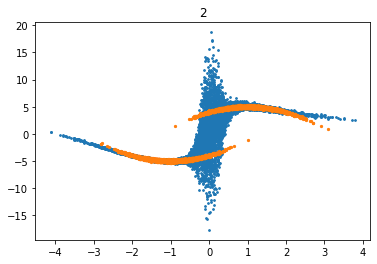

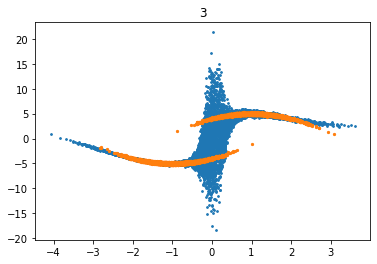

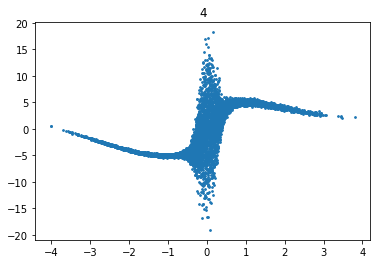

In [32]:
def sample(n,dist):
    p = dist.sample(n)
    px = p[...,0]
    py = p[...,1]
    return(px,py)
    
def train(base,X,Y):
    nsamples=10000
    ## NN setup
    # Set up bijector MADE
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[4,4], activation=tf.math.asinh) # not sure what hidden units are 

    target_distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(base),
        bijector=tfb.MaskedAutoregressiveFlow(made)) 

    # Construct model.
    x_ = tfk.Input(shape=(2,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  loss=lambda _, log_prob: -log_prob) 

    # adam is a 'stochastic' gradient descent algorithm
    # Don't quite understand the format of the loss function here. 

    # now perform the fit
    xdata = np.stack([X, Y], axis=-1)
    ydata = base.sample(nsamples)
    #print(data)
    plt.scatter(X,Y,s=5)

    batch_size = 100
    model.fit(x=xdata,
              y=np.zeros((int(nsamples), 2), dtype=np.float32),
              batch_size=batch_size,
              epochs=100,
              steps_per_epoch=50,  # Usually `n // batch_size`.
              validation_split=0.2,
              shuffle=True,
              verbose=True) #, ydata
    
    return(target_distribution)
    
def plot(x,y,title):
    plt.figure()
    plt.title(title)
    plt.scatter(x,y,s=3)
    
trained_dist = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])

#init samples
nsamples=10000
center = 1
stdevx = 0.5
stdevy = 0.1
shifty = 5

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))

x = np.concatenate([X1,X2])
y = np.concatenate([Y1,Y2])

plot(x,y,"init")

bijectors=[]
#dists=[]

n_runs = 5

for i in range(n_runs):
    #print(trained_dist)
    print('=====')
    print('run: '+str(i+1))
    print('=====')
    trained_dist = train(trained_dist,x,y)
    bijectors.append(trained_dist.bijector)
    sx,sy = sample(nsamples,trained_dist)
    #dists.append(samples)
    plot(sx,sy,str(i))
 
'''
#print(bijectors)
print(dists)
data = bijectors[1].forward(dists[1])
x = data[...,0]
y = data[...,1]
plot(x,y,'final')
'''

Epoch 1/100
200/200 [==============================] - 2s 5ms/step - loss: 5.2334 - val_loss: 3.8340
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 3.2186 - val_loss: 3.7459
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 3.0148 - val_loss: 3.7293
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 2.9975 - val_loss: 3.7571
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 2.9905 - val_loss: 3.7465
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 2.9762 - val_loss: 3.7256
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 2.9573 - val_loss: 3.7018
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 2.9294 - val_loss: 3.7178
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 2.9073 - val_loss: 3.6922
Epoch 10/100
200/200 [==============================] - 1s 4ms/step - loss: 2.8745 - val_lo

200/200 [==============================] - 1s 4ms/step - loss: 2.6165 - val_loss: 3.2052
Epoch 82/100
200/200 [==============================] - 1s 4ms/step - loss: 2.6206 - val_loss: 3.3299
Epoch 83/100
200/200 [==============================] - 1s 4ms/step - loss: 2.6136 - val_loss: 3.3745
Epoch 84/100
200/200 [==============================] - 1s 4ms/step - loss: 2.6185 - val_loss: 3.2782
Epoch 85/100
200/200 [==============================] - 1s 3ms/step - loss: 2.6283 - val_loss: 3.1842
Epoch 86/100
200/200 [==============================] - 1s 3ms/step - loss: 2.6102 - val_loss: 3.1420
Epoch 87/100
200/200 [==============================] - 1s 3ms/step - loss: 2.6218 - val_loss: 3.2222
Epoch 88/100
200/200 [==============================] - 1s 3ms/step - loss: 2.6182 - val_loss: 3.2845
Epoch 89/100
200/200 [==============================] - 1s 4ms/step - loss: 2.6174 - val_loss: 3.1501
Epoch 90/100
200/200 [==============================] - 1s 4ms/step - loss: 2.6198 - val_loss: 

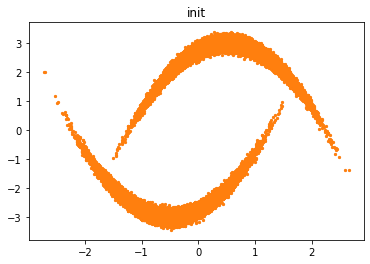

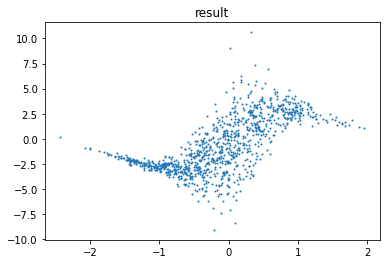

In [141]:
def sample(n,dist):
    p = dist.sample(n)
    px = p[...,0]
    py = p[...,1]
    return (px,py,p)
    
def train(base,X,Y,n_maf,n,batch_size,permute):
    nsamples=n
    ## NN setup
    # Set up bijector MADE
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[4,4], activation=tf.math.asinh, kernel_initializer='glorot_uniform')
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(2) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        # The x direction does not want to separate, so I want to see if permuting the input can help
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
        
    target_distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(base),
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(2,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  loss=lambda _, log_prob: -log_prob) 

    # now perform the fit
    xdata = np.stack([X, Y], axis=-1)
    ydata = base.sample(nsamples)
    #print(data)
    plt.scatter(X,Y,s=5)

    #batch_size = 1000
    model.fit(x=xdata,
              y=np.zeros((int(2*nsamples), 2), dtype=np.float32),
              batch_size=batch_size,
              epochs=100,
              steps_per_epoch=n/batch_size,  # Usually `n // batch_size`.
              validation_split=0.2,
              shuffle=True,
              verbose=True) #, ydata
    
    return(target_distribution)
    
def plot(x,y,title):
    plt.figure()
    plt.title(title)
    plt.scatter(x,y,s=1)
    
trained_dist = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])

#init samples
nsamples=100000
center = 0.5
stdevx = 0.5
stdevy = 0.1
shifty = 3

X1 = np.random.normal(-1*center, stdevx, nsamples)
X2 = np.random.normal(center, stdevx, nsamples) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, nsamples)
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy, nsamples)

x = np.concatenate([X1,X2])
y = np.concatenate([Y1,Y2])

plot(x,y,"init")

bijectors=[]
#dists=[]

#n_mafs = 10
trained_dist = train(trained_dist,x,y,n_maf=5,n=nsamples,batch_size=500,permute=False)

'''
for i in range(n_runs):
    #print(trained_dist)
    print('=====')
    print('run: '+str(i+1))
    print('=====')
    trained_dist = train(trained_dist,x,y)
    bijectors.append(trained_dist.bijector)
    sx,sy = sample(nsamples,trained_dist)
    #dists.append(samples)
    plot(sx,sy,str(i))
'''
tx,ty,txy=sample(1000,trained_dist)
plot(tx,ty,'result')


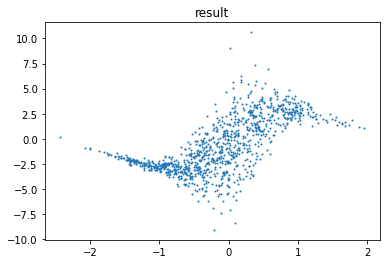

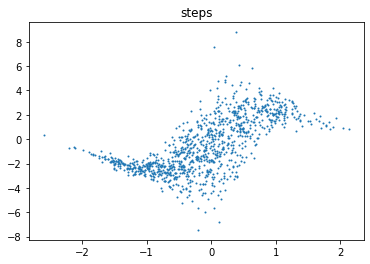

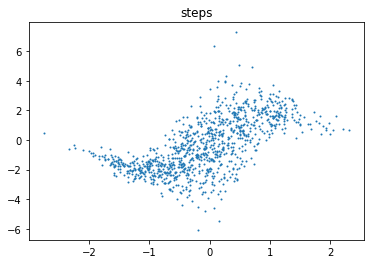

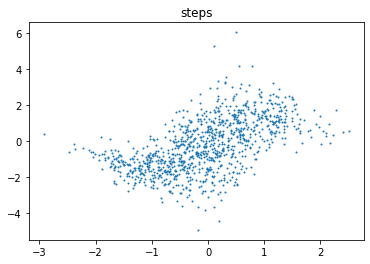

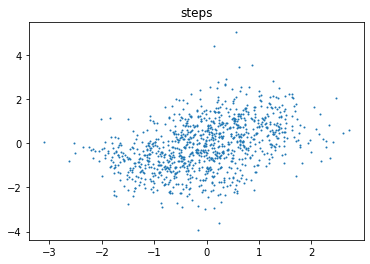

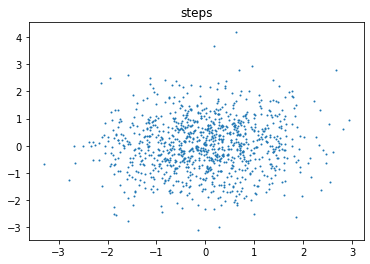

In [142]:
plot(tx,ty,'result')
l_bijectors = np.array(trained_dist.bijector.bijectors)#np.flipud()
step_data=txy
for bij in l_bijectors:
    step_data = bij.inverse(step_data)
    plot(step_data[...,0],step_data[...,1],'steps')

Not symmetric about origin example

Epoch 1/100
20/20 [==============================] - 1s 15ms/step - loss: 8.6419 - val_loss: 7.8265
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 4.7852 - val_loss: 7.2485
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 4.3890 - val_loss: 6.6540
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 3.7851 - val_loss: 5.9216
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 3.3155 - val_loss: 4.9561
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 2.9241 - val_loss: 4.0286
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 2.6226 - val_loss: 3.5283
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5274 - val_loss: 3.5663
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5192 - val_loss: 3.5987
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5188 - val_loss: 3.6306
Epoch 11

20/20 [==============================] - 0s 3ms/step - loss: 2.5008 - val_loss: 3.8229
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5119 - val_loss: 3.8234
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 2.4840 - val_loss: 3.8378
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5163 - val_loss: 3.8256
Epoch 87/100
20/20 [==============================] - 0s 3ms/step - loss: 2.5003 - val_loss: 3.8208
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 2.4947 - val_loss: 3.8169
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5042 - val_loss: 3.8180
Epoch 90/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5135 - val_loss: 3.8179
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 2.4931 - val_loss: 3.8222
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 2.4989 - val_loss: 3.8164
Epoch 93/100


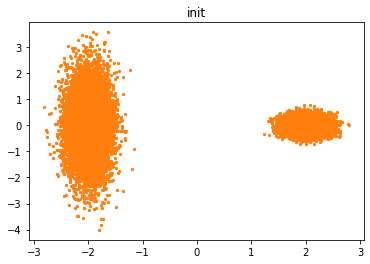

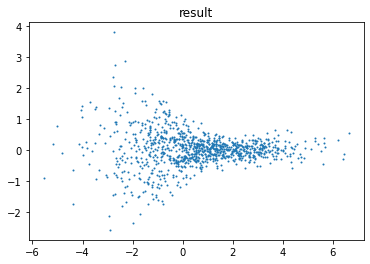

In [210]:
def sample(n,dist):
    p = dist.sample(n)
    px = p[...,0]
    py = p[...,1]
    return (px,py,p)
    
def train(base,X,Y,n_maf,n,batch_size,permute):
    nsamples=n
    ## NN setup
    # Set up bijector MADE
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation=tf.math.asinh, kernel_initializer='glorot_uniform')
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(2) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        # The x direction does not want to separate, so I want to see if permuting the input can help
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
        
    target_distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(base),
        bijector=tfb.Chain(bijectors)) 

    
    # now perform the fit
    xdata = np.stack([X, Y], axis=-1)
    ydata = base.sample(nsamples)
    #print(data)
    plt.scatter(X,Y,s=5)

    # Construct model.
    x_ = tfk.Input(shape=(2,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=lambda _, log_prob: -log_prob) 

    #batch_size = 1000
    model.fit(x=xdata,
              y=np.zeros((int(2*nsamples), 2), dtype=np.float32),
              batch_size=batch_size,
              epochs=100,
              steps_per_epoch=n/batch_size,  # Usually `n // batch_size`.
              validation_split=0.2,
              shuffle=True,
              verbose=True) #, ydata
    
    return(target_distribution)
    
def plot(x,y,title):
    plt.figure()
    plt.title(title)
    plt.scatter(x,y,s=1)
    
trained_dist = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])

#init samples
nsamples=10000
center = 2
stdevx = 0.2
stdevy = 0.2
shifty = 0

X1 = np.random.normal(center, stdevx, nsamples)
X2 = np.random.normal(-center, stdevx, nsamples) 
Y1 = np.random.normal(shifty, stdevy, nsamples)
Y2 = np.random.normal(shifty,5*stdevy, nsamples)

x = np.concatenate([X1,X2])
y = np.concatenate([Y1,Y2])

plot(x,y,"init")

bijectors=[]
#dists=[]

#n_mafs = 10
trained_dist = train(trained_dist,x,y,n_maf=5,n=nsamples,batch_size=500,permute=False)

'''
for i in range(n_runs):
    #print(trained_dist)
    print('=====')
    print('run: '+str(i+1))
    print('=====')
    trained_dist = train(trained_dist,x,y)
    bijectors.append(trained_dist.bijector)
    sx,sy = sample(nsamples,trained_dist)
    #dists.append(samples)
    plot(sx,sy,str(i))
'''
tx,ty,txy=sample(1000,trained_dist)
plot(tx,ty,'result')


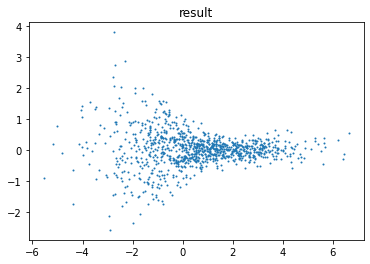

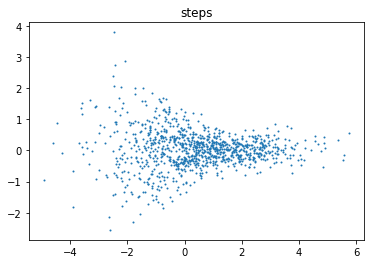

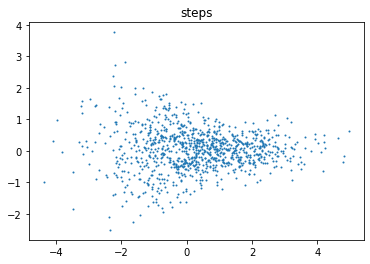

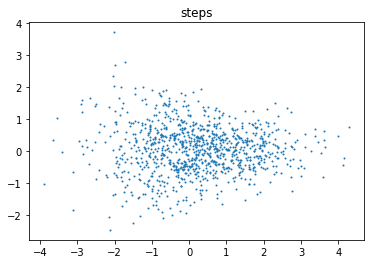

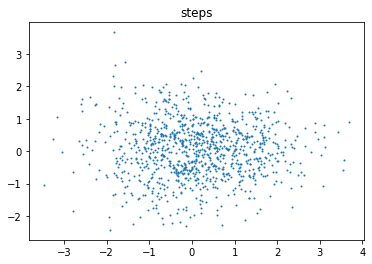

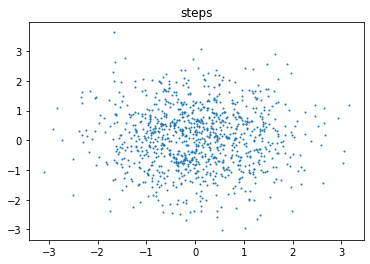

In [211]:
plot(tx,ty,'result')
l_bijectors = np.array(trained_dist.bijector.bijectors)#np.flipud()
step_data=txy
for bij in l_bijectors:
    step_data = bij.inverse(step_data)
    plot(step_data[...,0],step_data[...,1],'steps')